In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
import numpy as np
import pandas as pd
import os
import sys
from keras.optimizers import Adam
import skimage.io
from multiprocessing import Pool
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
import pickle
import re

Using TensorFlow backend.


# Prep and input of data

In [2]:
train_data = 'data/training/necklaces'
test_data = 'data/testing/necklaces'

In [3]:
img_size = 100

In [4]:
def train_data_with_label():
    train_images = []
    train_ids = []
    for i in tqdm(os.listdir(train_data)):
        path = os.path.join(train_data, i)
        train_ids.append(path)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size,img_size))
        train_images.append(np.array(img))
#         shuffle(train_images)
    return train_images, train_ids

def test_data_with_label():
    test_images = []
    test_ids = []
    for i in tqdm(os.listdir(test_data)):
        path = os.path.join(test_data, i)
        test_ids.append(path)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_size,img_size))
        test_images.append(np.array(img))
    return test_images, test_ids

In [5]:
# Get the images and put them into np arrays and resize them; Also keeping track of the product ids
testing_images, testing_ids = test_data_with_label()
training_images, training_ids = train_data_with_label()

100%|██████████| 1000/1000 [00:06<00:00, 167.47it/s]


In [6]:
def read_images_in_dir(datadir, img_height, img_width):
    images = []
    image_ids = []
    for i in tqdm(os.listdir(datadir)):
        path = os.path.join(datadir, i)
        image_ids.append(os.path.splitext(os.path.basename(path))[0])
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_height, img_width))
        images.append(np.array(img))
    return images, image_ids 

In [7]:
a, b = read_images_in_dir('data/testing/necklaces', 100, 100)

100%|██████████| 500/500 [00:02<00:00, 184.38it/s]


In [8]:
b

['785053996',
 '465332558',
 '787758991',
 '770897518',
 '732642851',
 '777440652',
 '761621519',
 '794362901',
 '761768131',
 '809953296',
 '809006600',
 '793924264',
 '797226965',
 '803129135',
 '803677548',
 '783355801',
 '788076453',
 '533313074',
 '697549012',
 '753087297',
 '732408711',
 '751681039',
 '464686136',
 '801083808',
 '800122451',
 '437859008',
 '791730890',
 '796546919',
 '809303648',
 '741514802',
 '803740293',
 '782337001',
 '808859485',
 '797515305',
 '746004048',
 '765078076',
 '810249018',
 '807174937',
 '807791276',
 '774668971',
 '732395046',
 '786222267',
 '784975380',
 '801626418',
 '807372124',
 '740327015',
 '807142077',
 '793035703',
 '801224826',
 '809044784',
 '808070907',
 '747656251',
 '763897378',
 '807187075',
 '792843711',
 '791188996',
 '643583777',
 '808394813',
 '740326914',
 '792564086',
 '775061770',
 '771567415',
 '798944035',
 '740759102',
 '751232229',
 '770887651',
 '788510056',
 '788035784',
 '694695131',
 '803739190',
 '465334073',
 '7608

In [9]:
small_testing_images = testing_images[0:250]
small_training_images = training_images[0:500]

In [3]:
# dimensions of our images.
img_width, img_height = 100, 100
img_channel = 3

In [11]:
np.array(small_testing_images).shape

(250, 100, 100, 3)

In [12]:
tr_img_data = np.array([i[0] for i in training_images])
tst_img_data = np.array([i[0] for i in testing_images])

In [13]:
small_tr_img_data = np.array([i[0] for i in small_training_images])
small_tst_img_data = np.array([i[0] for i in small_testing_images])

In [14]:
tr_img_data.shape

(1000, 100, 3)

In [15]:
small_tst_img_data.shape

(250, 100, 3)

In [16]:
# normalize the images
tst_img_data = np.array(testing_images).astype('float32') / 255.
tr_img_data = np.array(training_images).astype('float32') / 255.

small_tst_img_data = np.array(small_testing_images).astype('float32') / 255.
small_tr_img_data = np.array(small_training_images).astype('float32') / 255.

In [17]:
tr_img_data.shape
small_tr_img_data.shape

(500, 100, 100, 3)

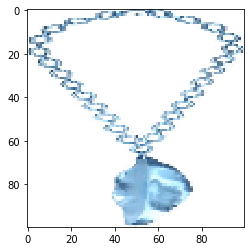

In [18]:
plt.imshow(small_tr_img_data[10].reshape(img_width, img_height,3))

# CNN Architecture

In [4]:
input_img = Input(shape=(img_width, img_height, img_channel))  # adapt this if using `channels_first` image data format
n_hidden_1, n_hidden_2, n_hidden_3= 16, 8, 8
convkernel = (3,3) # convolution kernal
poolkernel = (2,2) #pooling kernal

x = Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(input_img)
x = MaxPooling2D(poolkernel, padding='same')(x)
x = Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
x = MaxPooling2D(poolkernel, padding='same')(x)
x = Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
encoded = MaxPooling2D(poolkernel, padding='same')(x)

x = Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(encoded)
x = UpSampling2D(poolkernel)(x)
x = Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
x =  UpSampling2D(poolkernel)(x)
x =  Conv2D(n_hidden_1, convkernel, activation='relu')(x)
x = UpSampling2D(poolkernel)(x)
decoded =  Conv2D(img_channel, convkernel, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0   

In [21]:
tr_img_data.shape

(1000, 100, 100, 3)

In [22]:
tst_img_data.shape

(500, 100, 100, 3)

In [23]:
autoencoder_train = autoencoder.fit(
    small_tr_img_data, small_tr_img_data,
    validation_data = (small_tst_img_data,small_tst_img_data),
    batch_size=32,
    epochs=50,
    verbose=1,
)

Train on 500 samples, validate on 250 samples
Epoch 1/50
500/500 [==============================] - 5s 10ms/step - loss: 0.6528 - val_loss: 0.4953
Epoch 2/50
500/500 [==============================] - 5s 10ms/step - loss: 0.3292 - val_loss: 0.2812
Epoch 3/50
500/500 [==============================] - 5s 10ms/step - loss: 0.2676 - val_loss: 0.2708
Epoch 4/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2539 - val_loss: 0.2553
Epoch 5/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2405 - val_loss: 0.2385
Epoch 6/50
500/500 [==============================] - 5s 9ms/step - loss: 0.2236 - val_loss: 0.2218
Epoch 7/50
500/500 [==============================] - 5s 10ms/step - loss: 0.2100 - val_loss: 0.2111
Epoch 8/50
500/500 [==============================] - 5s 10ms/step - loss: 0.2008 - val_loss: 0.2043
Epoch 9/50
500/500 [==============================] - 5s 10ms/step - loss: 0.1958 - val_loss: 0.2006
Epoch 10/50
500/500 [===========================

In [8]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

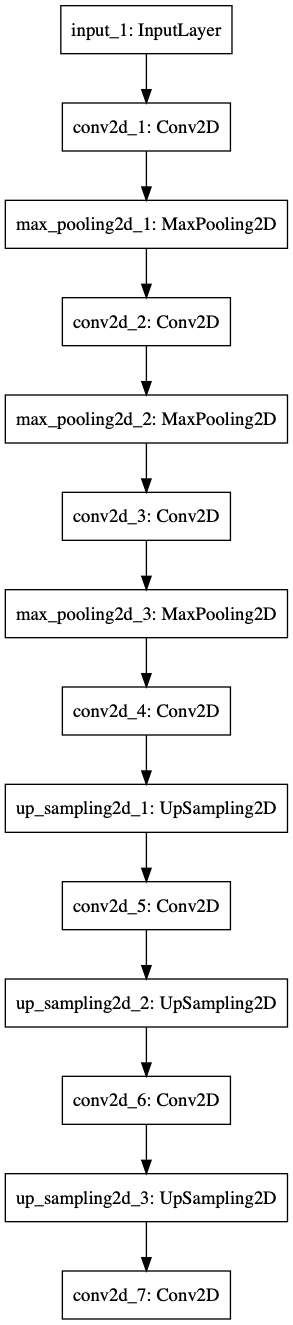

In [11]:
from keras.utils import plot_model
plot_model(encoder, to_file='cnn_encoder_model_final.png')
plot_model(autoencoder, to_file='cnn_autencoder_model_final.png')

In [25]:
encoder

In [26]:
# encode some digits
# note that we take them from the *test* set
encoded_train_imgs = encoder.predict(small_tr_img_data)
encoded_test_imgs = encoder.predict(small_tst_img_data)

In [27]:
encoded_train_imgs.shape

(500, 13, 13, 8)

In [28]:
encoded_test_imgs.shape

(250, 13, 13, 8)

In [29]:
# flatten the img, so they are the shape (#imgs, height*width*channels of output of encoder)
encoded_train_imgs_flat = encoded_train_imgs.reshape((-1, np.prod(encoded_train_imgs.shape[1:])))
encoded_test_imgs_flat = encoded_test_imgs.reshape((-1, np.prod(encoded_test_imgs.shape[1:])))

In [30]:
encoded_test_imgs_flat.shape

(250, 1352)

In [31]:
encoded_test_imgs_flat[0]

array([0.        , 0.49314174, 0.07334169, ..., 0.628855  , 0.        ,
       0.        ], dtype=float32)

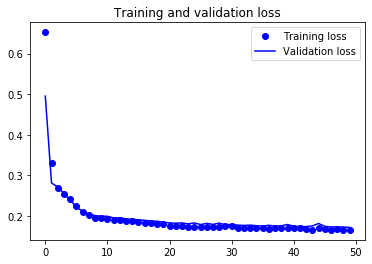

In [32]:
# Training vs Validation Loss Plot
loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Validation loss and the training loss both are in sync. It shows that your model is not overfitting: the validation loss is decreasing and not increasing, and there rarely any gap between training and validation loss.

In [14]:
decoder = Model(input_img, decoded)
decoded_train = decoder.predict(small_tr_img_data)

NameError: name 'small_tr_img_data' is not defined

# Trying KNN

In [33]:
# Making Training set with the encoded layer
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(encoded_train_imgs_flat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [34]:
encoded_train_imgs_flat.shape

(500, 1352)

In [35]:
# Save the trained model as a pickle string. 
pickle_name = 'jewelry_knn_test.sav'
pickle.dump(knn, open(pickle_name, 'wb')) 

In [55]:
test_img = 3

In [56]:
# Predict KNN for a test image
distances, indices = knn.kneighbors(encoded_test_imgs_flat[test_img].reshape(1, -1))

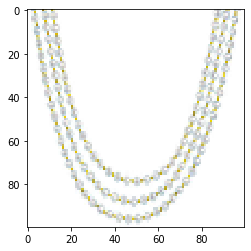

In [57]:
# Print the test image
plt.imshow(small_testing_images[test_img].reshape(100, 100, 3))

In [58]:
# indices for the neighbors in the training data set
indices

array([[306, 371, 409, 352,  19]])

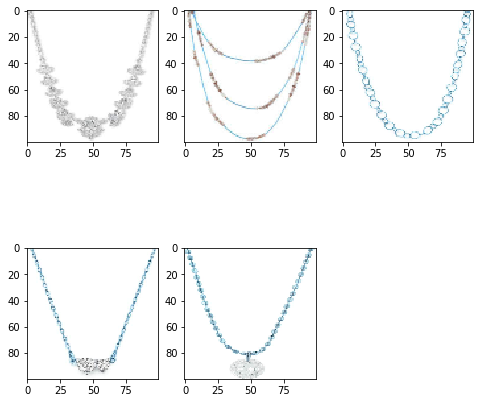

In [59]:
# n_neighbors of the test image
fig= plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i, idx in zip(range(1, columns*rows +1), np.nditer(indices)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(small_training_images[idx].reshape(100, 100, 3))
plt.show()

# WOOOT

# Tesing Pickle

In [41]:
import pickle
filename = 'jewelry_knn_test.sav'
knn = pickle.load(open(filename, 'rb'))
knn

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

# Trying KNN and price filtering

In [42]:
product_meta = pd.read_csv('data/product_metadata.csv')
product_meta.head()

,id,name,price,clickUrl,category_numID
0,7242404,Gurhan Women&s;s Amulet 24K Yellow Gold Dome D...,1850.0,https://www.shopstyle.com/action/loadRetailerP...,72
1,7636349,Royalty Inspired by Effy Sapphire (1-9/10 ct. ...,2300.0,https://www.shopstyle.com/action/loadRetailerP...,73
2,26292586,Le Vian Chocolate Diamond (3/4 ct. t.w.) and W...,1900.0,https://www.shopstyle.com/action/loadRetailerP...,420
3,26334781,Royalty Inspired by Effy Emerald (5/8 ct. t.w....,800.0,https://www.shopstyle.com/action/loadRetailerP...,68
4,31658464,Majorica Women&s;s 11mm Round Simulated Pearl ...,80.0,https://www.shopstyle.com/action/loadRetailerP...,72


In [43]:
# Making Training set with the encoded layer
knn_price = NearestNeighbors(n_neighbors=10, metric="cosine")
knn_price.fit(encoded_train_imgs_flat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [60]:
test_img = 216

# Predict KNN for a test image
distances, indices = knn_price.kneighbors(encoded_test_imgs_flat[test_img].reshape(1, -1))

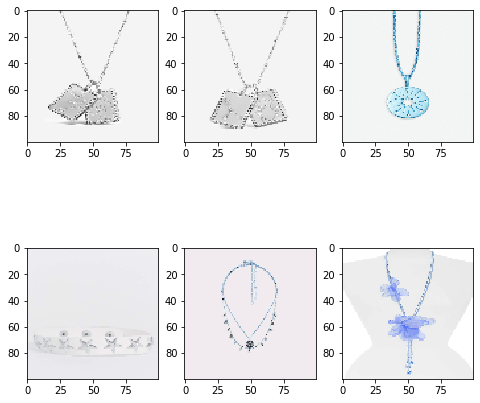

In [61]:
# n_neighbors of the test image
fig= plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i, idx in zip(range(1, columns*rows +1), np.nditer(indices)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(small_training_images[idx].reshape(100, 100, 3))
plt.show()

In [62]:
import re
re.split('[/.]', training_ids[0])[3]

'736758642'

In [63]:
def extract_id(id_list):
    cleaned_ids = []
    for i in id_list:
        cleaned_ids.append(re.split('[/.]', i)[3])
    return cleaned_ids

In [48]:
training_product_ids = extract_id(training_ids)

In [49]:
training_product_ids[115]

'730901263'

In [50]:
product_meta[product_meta['id'] == int(training_product_ids[115])]

,id,name,price,clickUrl,category_numID
5174,730901263,Splash by Effy Purple Sapphire Horizontal Bar ...,650.0,https://www.shopstyle.com/action/loadRetailerP...,73


In [51]:
indices[0]

array([443, 164, 107, 421, 492, 252, 329,  20, 118,  18])

In [68]:
price_limit = 100

indices_filtered = []
for i in indices[0]:
    img_id = training_product_ids[i]
    price = float(product_meta[product_meta['id'] == int(img_id)]['price'])   
    if price < price_limit:
        indices_filtered.append(i)
indices_filtered

[335, 387, 4, 217, 423, 143, 379, 124, 367]

In [90]:
def price_filter(neighbors, product_ids, product_data, price_limit):
    filtered_products = []
    product_prices = []
    product_urls = []
    for neighbor in neighbors:
        product_id = product_ids[neighbor]
        price = float(product_data[product_data['id'] == int(product_id)]['price'])
        url = str(product_data[product_data['id'] == int(product_id)]['clickUrl'])
        if price < price_limit:
            filtered_products.append(neighbor)
            product_prices.append(price)
            product_urls.append(url)
    return filtered_products, product_prices, product_urls         

In [198]:
type(training_product_ids)

list

In [91]:
filtered_products, product_prices, product_urls = price_filter(indices[0], 
                                                   training_product_ids, 
                                                   product_meta, 
                                                   price_limit)

In [94]:
filtered_products

[335, 387, 4, 217, 423, 143, 379, 124, 367]

Matches the image file!!!!

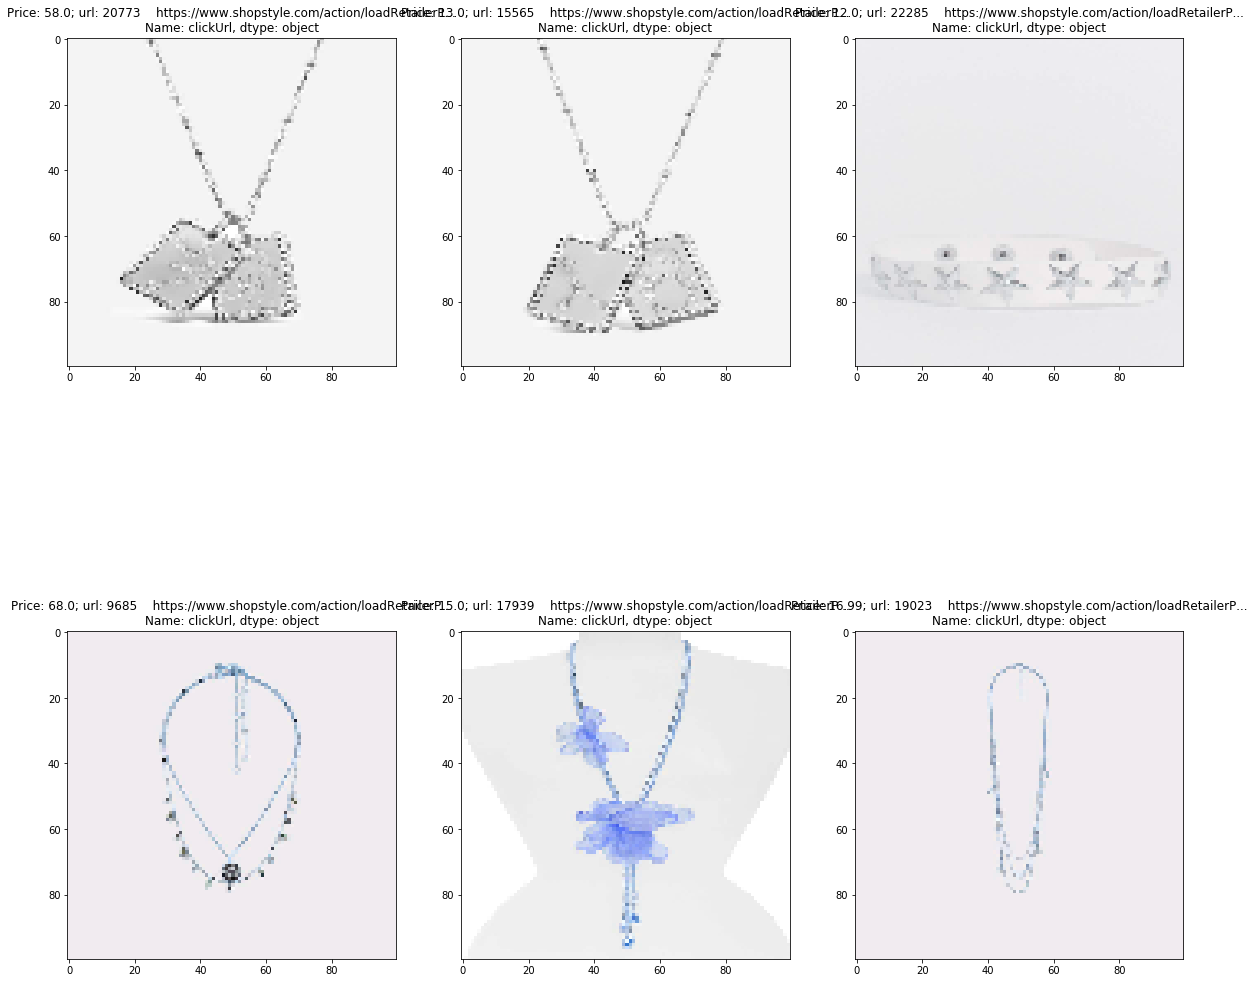

In [93]:
# n_neighbors of the test image
fig= plt.figure(figsize=(20, 20))
columns = 3
rows = 2
for i, idx in zip(range(1, columns*rows +1), filtered_products):
    fig.add_subplot(rows, columns, i)
    plt.imshow(training_images[idx].reshape(100, 100, 3))
    plt.title(f'Price: {product_prices[i]}; url: {product_urls[i]}')
plt.show()